# **Challenger la grille de score avec un modèle de Machine Learning**  

Nous allons tester l'**Arbre de Décision**, un modèle simple mais efficace. Il est particulièrement intéressant pour le scoring de crédit, car il offre une bonne **interprétabilité** en permettant de visualiser les règles de décision. De plus, il gère **naturellement les valeurs manquantes** et s’adapte aux **relations non linéaires**, ce qui en fait un candidat pertinent pour challenger la grille de score.

In [2]:
import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv("../data/data_cleaned.csv")

# Afficher les informations avant transformation
df.info()
print(df.head(5).to_string(index=False))

# Appliquer le One-Hot Encoding sur les colonnes catégorielles
df = pd.get_dummies(df, drop_first=True)

# Afficher les informations après encodage
df.info()

# Fonction de downcasting pour optimiser la mémoire
def downcast(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        # Downcast les types entiers
        if np.issubdtype(col_type, np.integer):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].between(np.iinfo(np.uint8).min, np.iinfo(np.uint8).max).all():
                df[col] = df[col].astype(np.uint8)
            elif df[col].between(np.iinfo(np.int8).min, np.iinfo(np.int8).max).all():
                df[col] = df[col].astype(np.int8)
            elif df[col].between(np.iinfo(np.uint16).min, np.iinfo(np.uint16).max).all():
                df[col] = df[col].astype(np.uint16)
            elif df[col].between(np.iinfo(np.int16).min, np.iinfo(np.int16).max).all():
                df[col] = df[col].astype(np.int16)
            elif df[col].between(np.iinfo(np.uint32).min, np.iinfo(np.uint32).max).all():
                df[col] = df[col].astype(np.uint32)
            elif df[col].between(np.iinfo(np.int32).min, np.iinfo(np.int32).max).all():
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)

        # Downcast les types flottants
        elif np.issubdtype(col_type, np.floating):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].between(np.finfo(np.float16).min, np.finfo(np.float16).max).all():
                df[col] = df[col].astype(np.float16)
            elif df[col].between(np.finfo(np.float32).min, np.finfo(np.float32).max).all():
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

        # Convertir les objets en catégories (sauf dates)
        elif df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            except:
                df[col] = df[col].astype('category')

    return df  

# Appliquer le downcasting
df = downcast(df)

# Vérification après downcasting
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252136 entries, 0 to 252135
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  252136 non-null  int64  
 1   GOOD_PAYER                  252136 non-null  int64  
 2   CODE_GENDER                 252136 non-null  object 
 3   FLAG_OWN_CAR                252136 non-null  object 
 4   FLAG_OWN_REALTY             252136 non-null  object 
 5   CNT_CHILDREN                252136 non-null  int64  
 6   AMT_INCOME_TOTAL            252136 non-null  float64
 7   AMT_CREDIT                  252136 non-null  float64
 8   NAME_INCOME_TYPE            252136 non-null  object 
 9   NAME_CONTRACT_TYPE          252136 non-null  object 
 10  NAME_EDUCATION_TYPE         252136 non-null  object 
 11  NAME_FAMILY_STATUS          252136 non-null  object 
 12  NAME_HOUSING_TYPE           252136 non-null  object 
 13  DAYS_BIRTH    

## Préparation du Modèle  
- Séparation des données en train/test (80/20)
- Utilisation de `stratify=y` pour conserver les proportions des classes
- Rééquilibrage des classes avec SMOTE    
- Optimisation des hyperparamètres

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['GOOD_PAYER'])  
y = df['GOOD_PAYER']  

# Split des données : 80% Train, 20% Test + stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ajuster le déséquilibre des classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Afficher les proportions des classes
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

# Optimisation des hyperparamètres
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 15)  # Plus profond = plus complexe
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Évite des branches trop petites
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Évite des feuilles isolées
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])  # Fonction de séparation

    model = DecisionTreeClassifier(
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, 
        criterion=criterion, 
        random_state=42
    )

    auc_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    auc_mean = auc_cv.mean()  # AUC moyen
    gini_mean = 2 * auc_mean - 1  # Calcul du Gini moyen
    
    return gini_mean

# Création de l'étude d'optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés : ", study.best_params)


/home/masterthomas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-03 12:28:55,916] A new study created in memory with name: no-name-d06e2428-8812-4882-9a9c-707986a22cf7


GOOD_PAYER
1    0.5
0    0.5
Name: proportion, dtype: float64
GOOD_PAYER
1    0.913401
0    0.086599
Name: proportion, dtype: float64


[W 2025-02-03 12:29:00,652] Trial 0 failed with parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'entropy'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/masterthomas/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34337/371703531.py", line 37, in objective
    auc_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
  File "/home/masterthomas/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/home/masterthomas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 684, in cross_val_score
    cv_results = cross_validate(
  File "/home/masterthomas/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwa

KeyboardInterrupt: 

## Entraînement du Modèle  
- Application des meilleurs hyperparamètres  
- Évaluation avec le calcul du Gini et de la matrice de confusion

Gini sur le jeu d'entraînement : 0.9099


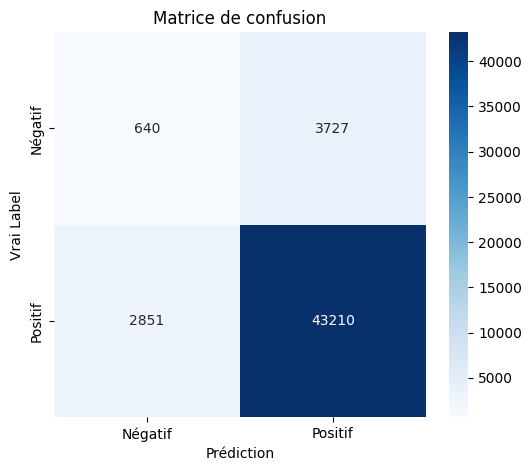

Rapport de classification :
               precision    recall  f1-score   support

           0       0.18      0.15      0.16      4367
           1       0.92      0.94      0.93     46061

    accuracy                           0.87     50428
   macro avg       0.55      0.54      0.55     50428
weighted avg       0.86      0.87      0.86     50428

Gini sur le jeu de test : 0.3209


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Entraîner le modèle final
best_model = DecisionTreeClassifier(
    max_depth=15,               # Éviter un arbre trop profond qui surajuste
    min_samples_split=19,      # Empêcher des divisions sur très peu d'exemples
    min_samples_leaf=5,        # Éviter des feuilles trop petites et surapprentissage
    criterion='entropy',          # "gini" souvent préféré pour stabilité, "entropy" si besoin d'information gain
    random_state=42
)

best_model.fit(X_train, y_train)

# Évaluation sur le jeu d'entraînement
y_train_proba = best_model.fit(X_train, y_train).predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_train_proba)
gini_train = 2 * auc_train - 1
print(f"Gini sur le jeu d'entraînement : {gini_train:.4f}")

# Évaluation sur le jeu de test
y_pred = best_model.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédiction")
plt.ylabel("Vrai Label")
plt.title("Matrice de confusion")
plt.show()

# Rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred))

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_pred_proba)
gini_test = 2 * auc_test - 1
print(f"Gini sur le jeu de test : {gini_test:.4f}")

## Interprétabilité du modèle de Machine Learning

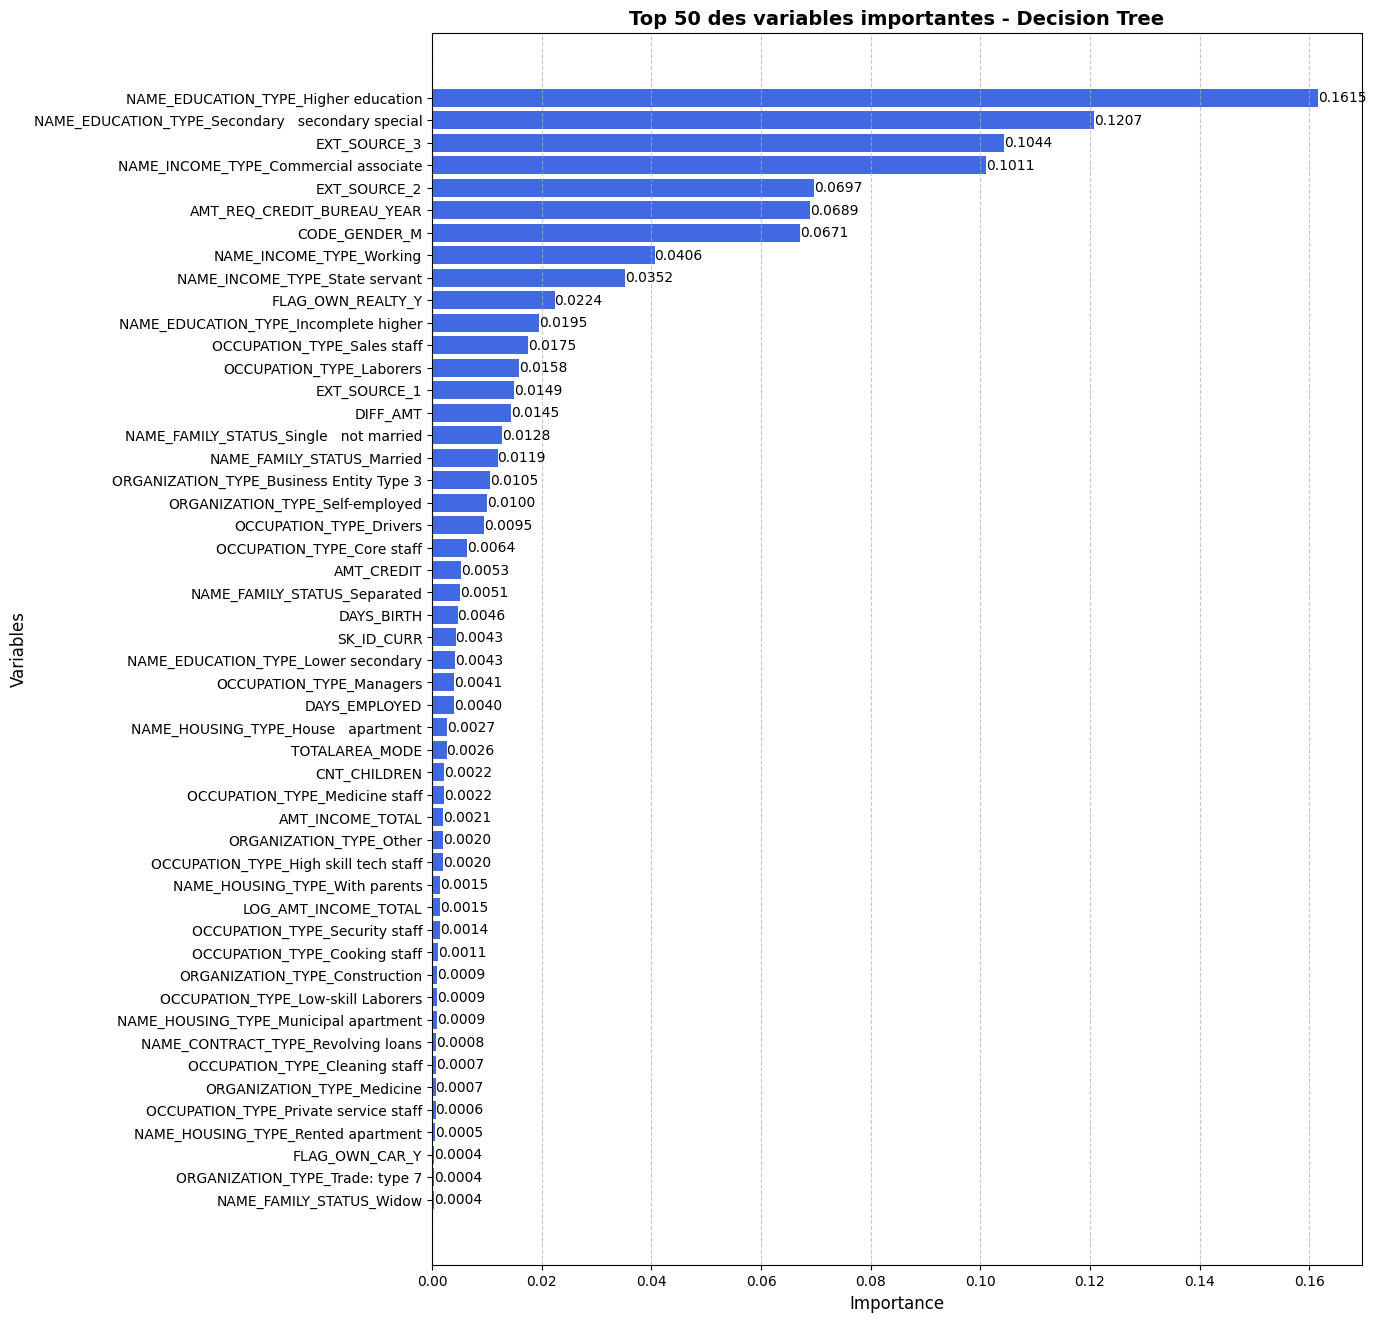

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtenir les importances des caractéristiques
importances = best_model.feature_importances_

# Créer une série pandas avec les importances et les noms des colonnes
importances_series = pd.Series(importances, index=X_train.columns)

# Sélectionner les 50 premières importances triées
top_importances = importances_series.sort_values(ascending=False).head(50)[::-1]  # Inversion pour avoir la plus importante en haut

# Création du graphique
plt.figure(figsize=(12, 16))
bars = plt.barh(top_importances.index, top_importances.values, color="royalblue")

# Ajouter les valeurs sur les barres
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.4f}', 
             va='center', ha='left', fontsize=10)

# Titre et labels
plt.title("Top 50 des variables importantes - Decision Tree", fontsize=14, fontweight="bold")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Affichage
plt.show()

## Impact économique


Seuil minimisant la perte sur Test = 0.89


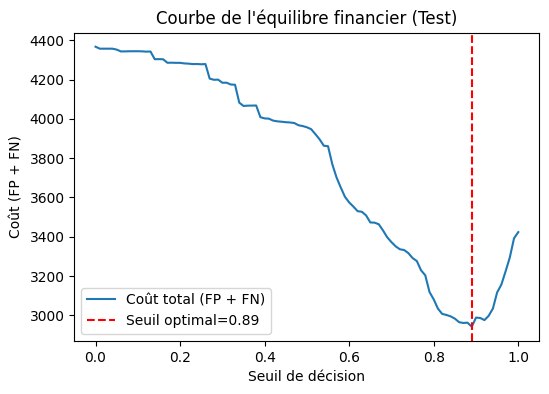

In [6]:
def economic_impact(y_true, y_proba, threshold):
    fp_cost = 1.0
    fn_cost = 0.08
    y_pred = (y_proba >= threshold).astype(int)
    fp = ((y_pred == 1) & (y_true == 0)).sum() * fp_cost
    fn = ((y_pred == 0) & (y_true == 1)).sum() * fn_cost
    return fp + fn

thresholds = np.linspace(0,1,101)
costs = [economic_impact(y_test, y_pred_proba, thr) for thr in thresholds]

optimal_thr = thresholds[np.argmin(costs)]
print(f"\nSeuil minimisant la perte sur Test = {optimal_thr:.2f}")

# Tracer la courbe des coûts en fonction du seuil
plt.figure(figsize=(6,4))
plt.plot(thresholds, costs, label="Coût total (FP + FN)")
plt.axvline(optimal_thr, color='red', linestyle='--', label=f"Seuil optimal={optimal_thr:.2f}")
plt.title("Courbe de l'équilibre financier (Test)")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût (FP + FN)")
plt.legend()
plt.show()